In [4]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(taxyvr)
library(cowplot)

In [5]:
original_data <- read_csv("ds_salaries.csv")
head(original_data)

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


In [58]:
# cleaning the data
clean_data <- original_data %>%
    filter(!is.na(salary_in_usd),
        employee_residence %in% c("CA", "GB"),
            employment_type == "FT") %>%
    select(salary_in_usd, employee_residence, job_title, experience_level)

head(clean_data)


salary_in_usd,employee_residence,job_title,experience_level
<dbl>,<chr>,<chr>,<chr>
109024,GB,Big Data Engineer,SE
117104,CA,Machine Learning Manager,SE
112872,GB,Data Engineer,MI
76958,GB,Data Scientist,MI
82528,GB,Research Scientist,EN
54238,GB,Applied Data Scientist,MI


[1] 96981.21

[1] 81403.16

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


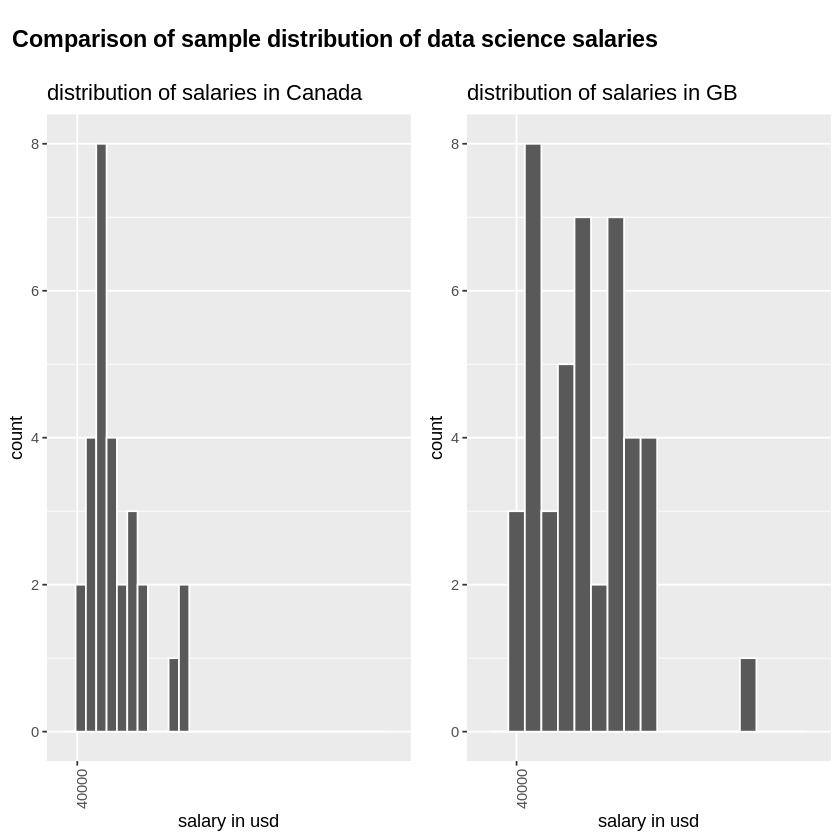

In [22]:
ca_salary_mean <- 
    clean_data %>%
    filter(employee_residence == "CA") %>%
    summarise(mean_salary = mean(salary_in_usd)) %>%
    pull()

ca_salary_mean

gb_salary_mean <-
    clean_data %>%
    filter(employee_residence == "GB") %>%
    summarise(mean_salary = mean(salary_in_usd)) %>%
    pull()

gb_salary_mean

ca_salary_plot <-
    clean_data %>%
    filter(employee_residence == "CA") %>%
    ggplot(aes(x = salary_in_usd)) + 
    geom_histogram(binwidth = 15000, color="white") +
    xlab("salary in usd") +
    ggtitle("distribution of salaries in Canada")



gb_salary_plot <-
    clean_data %>%
    filter(employee_residence == "GB") %>%
    ggplot(aes(x = salary_in_usd)) + 
    geom_histogram(binwidth = 10000, color="white") +
    xlab("salary in usd") +
    ggtitle("distribution of salaries in GB")


plot_salaries <- plot_grid(ca_salary_plot +
                theme(axis.text.x = element_text(angle = 90)) +
                scale_x_continuous(breaks = seq(40000, 120000, 200000),
                                   limits = c(20000, 500000)),
                gb_salary_plot + 
                theme(axis.text.x = element_text(angle = 90)) +
                scale_x_continuous(breaks = seq(40000, 120000, 200000),
                                   limits = c(20000, 220000)),
                ncol = 2)

title <- ggdraw() +
    draw_label("Comparison of sample distribution of data science salaries",
                fontface = 'bold',
                x = 0,
                hjust = 0) +
    theme(plot.margin = margin(0, 0, 0, 7))

salary_grid <- plot_grid(title, plot_salaries, ncol = 1, rel_heights = c(0.1, 1))

salary_grid

In [65]:
number_small <- original_data %>%
    summarise(number_small = sum(company_size == "S")) %>%
    pull()

number_medium <- original_data %>%
    summarise(number_medium = sum(company_size == "M")) %>%
    pull()

number_large <- original_data %>%
    summarise(number_large = sum(company_size == "L")) %>%
    pull()

number_small
number_medium
number_large

[1] 83

[1] 326

[1] 198

In [66]:
clean_data2 <- original_data %>%
    filter(!is.na(salary_in_usd),
            employment_type == "FT") %>%
    select(salary_in_usd, employee_residence, job_title, experience_level, company_size)

head(clean_data2)

salary_in_usd,employee_residence,job_title,experience_level,company_size
<dbl>,<chr>,<chr>,<chr>,<chr>
79833,DE,Data Scientist,MI,L
260000,JP,Machine Learning Scientist,SE,S
109024,GB,Big Data Engineer,SE,M
20000,HN,Product Data Analyst,MI,S
150000,US,Machine Learning Engineer,SE,L
72000,US,Data Analyst,EN,L


In [67]:
small_salary_mean <- 
    clean_data2 %>%
    filter(company_size == "S") %>%
    summarise(mean_salary = mean(salary_in_usd)) %>%
    pull()

medium_salary_mean <- 
    clean_data2 %>%
    filter(company_size == "M") %>%
    summarise(mean_salary = mean(salary_in_usd)) %>%
    pull()

large_salary_mean <- 
    clean_data2 %>%
    filter(company_size == "L") %>%
    summarise(mean_salary = mean(salary_in_usd)) %>%
    pull()

small_salary_mean
medium_salary_mean
large_salary_mean

[1] 76484

[1] 118662.1

[1] 119665.4

In [68]:
ca_salary_median <- 
    clean_data %>%
    filter(employee_residence == "CA") %>%
    summarise(median_salary = median(salary_in_usd)) %>%
    pull()

gb_salary_median <-
    clean_data %>%
    filter(employee_residence == "GB") %>%
    summarise(median_salary = median(salary_in_usd)) %>%
    pull()

ca_salary_median
gb_salary_median

[1] 81895.5

[1] 78526